In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import joblib

***

### Reading the data from the .csv file.

In [2]:
df = pd.read_csv("./completed_tasks.csv")
df.columns

Index(['id', 'task_id', 'user_id', 'started_date', 'completed_date', 'hours',
       'user_level', 'task_difficulty'],
      dtype='object')

### Data Cleaning and analyzing some data.

In [3]:
df = df.drop(columns=['id','started_date', 'completed_date'])

In [4]:
# How many rows are there?
df.count()

task_id            1000
user_id            1000
hours              1000
user_level         1000
task_difficulty    1000
dtype: int64

In [5]:
df.sort_values('hours')

,task_id,user_id,hours,user_level,task_difficulty
523,698,1,0,10,1
197,274,13,1,10,1
768,34,1,1,10,1
856,249,13,2,10,1
709,687,13,2,10,2
...,...,...,...,...,...
207,399,12,36,1,10
465,850,2,36,1,10
869,607,19,36,1,10
55,706,19,37,1,10


In [6]:
df.head()

,task_id,user_id,hours,user_level,task_difficulty
0,471,9,6,9,4
1,700,17,5,9,2
2,114,10,15,6,5
3,183,9,9,9,4
4,479,8,16,2,1


In [7]:
df.describe()

,task_id,user_id,hours,user_level,task_difficulty
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,500.500000,10.351000,18.889000,5.519000,5.50300
std,288.819436,5.860046,7.544773,2.971611,2.86744
min,1.000000,1.000000,0.000000,1.000000,1.00000
25%,250.750000,6.000000,14.000000,3.000000,3.00000
50%,500.500000,10.000000,19.000000,5.000000,5.00000
75%,750.250000,16.000000,24.000000,9.000000,8.00000
max,1000.000000,20.000000,38.000000,10.000000,10.00000


In [8]:
df.dtypes

task_id            int64
user_id            int64
hours              int64
user_level         int64
task_difficulty    int64
dtype: object

In [9]:
# Check if there is any null values so that a clearance is required.
df.isnull().sum()

task_id            0
user_id            0
hours              0
user_level         0
task_difficulty    0
dtype: int64

In [10]:
# Remove rows that contain missing values
df.dropna(inplace=True)

In [11]:
# Task id must be unique. One task can only be completed once.
df['task_id'].is_unique

True

In [12]:
# Remove duplicate rows based on specific columns
df.drop_duplicates(subset=['task_id'], inplace=True)

### Cleaning the outliers by calculating the upper and lower bounds using Numpy functions. Part of the data cleaning process.

In [13]:
grouped = df.groupby(['user_level', 'task_difficulty'])

# Calculate the 25th and 75th percentiles for each group
q25 = grouped['hours'].transform(lambda x: np.quantile(x, 0.25))
q75 = grouped['hours'].transform(lambda x: np.quantile(x, 0.75))

# Calculate the interquartile range (IQR) for each group
iqr = q75 - q25

# Define the upper and lower bounds for outliers
upper_bound = q75 + 1.5 * iqr
lower_bound = q25 - 1.5 * iqr

# Filter the DataFrame to remove rows with hours outside the bounds
df = df[(df['hours'] >= lower_bound) & (df['hours'] <= upper_bound)]

In [14]:
# Count rows after cleaning the outliers.
df.count()

task_id            983
user_id            983
hours              983
user_level         983
task_difficulty    983
dtype: int64

***

### Understanding the dataset using graphs.

#### Scatter map showing the relation between "user_level" and "hours".

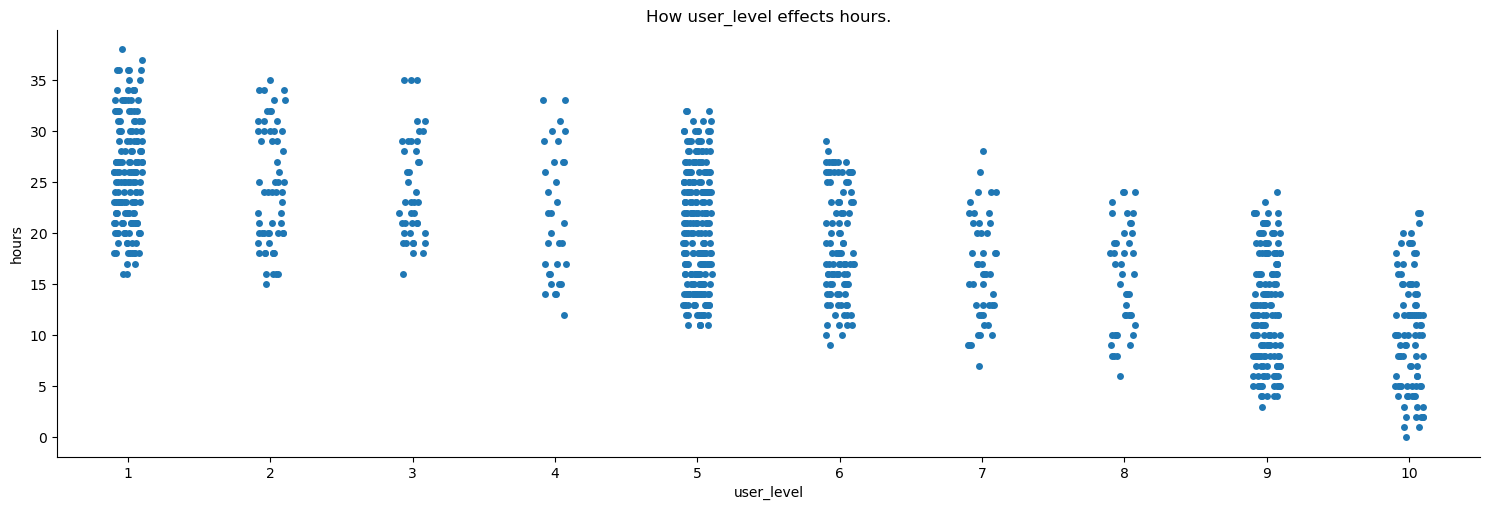

In [15]:
sns.catplot(x='user_level', y='hours', data=df, height=5, aspect=3)
plt.gca().set_title('How user_level effects hours.');

#### Scatter map showing the relation between "task_difficulty" and "hours".

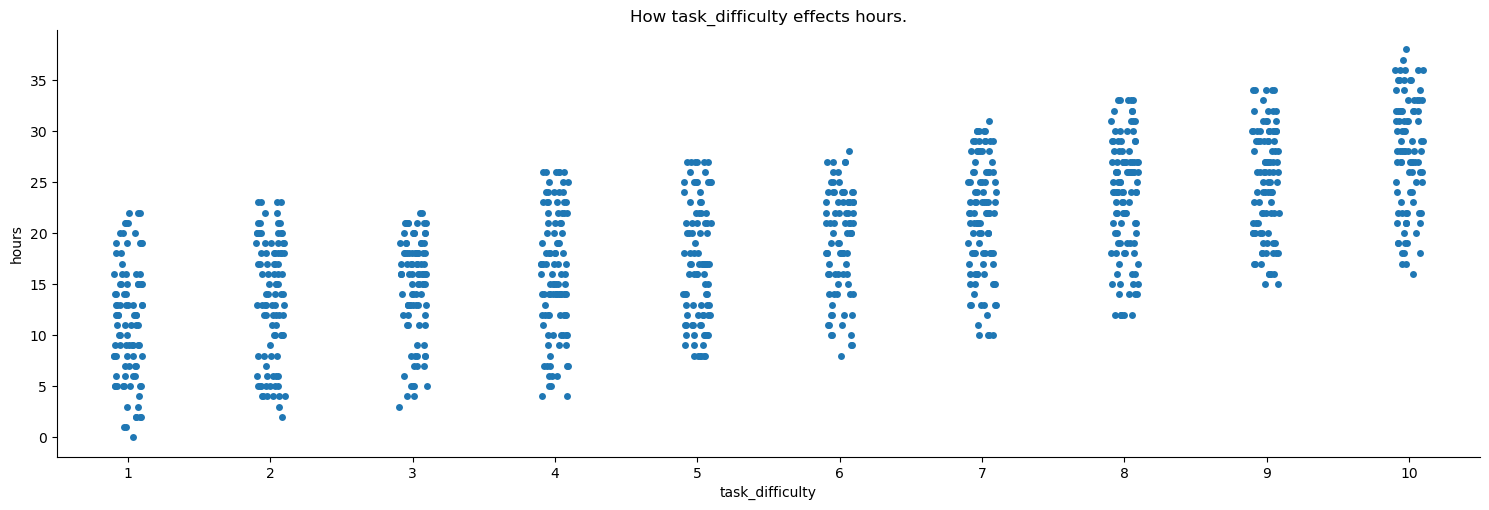

In [16]:
sns.catplot(x='task_difficulty', y='hours', data=df, height=5, aspect=3)
plt.gca().set_title('How task_difficulty effects hours.');

#### Heatmap showing the relation between "user_level", "task_difficulty", and "hours".

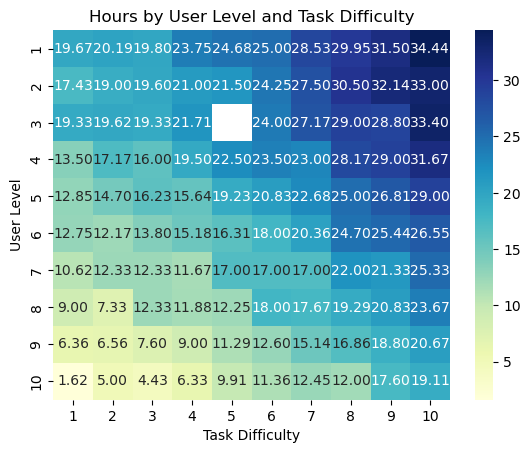

In [17]:
# Shows the 'hours' according to 'user_level', and 'task_difficulty' on a heatmap.

# Pivot the DataFrame to create a 2D table of hours by user_level and task_difficulty
pivoted_data = df.pivot_table(values='hours', index='user_level', columns='task_difficulty', aggfunc='mean')

# Create a heatmap using Seaborn
sns.heatmap(pivoted_data, cmap='YlGnBu', annot=True, fmt='.2f', annot_kws={'size': 10})

# Add some labels and title
plt.xlabel('Task Difficulty')
plt.ylabel('User Level')
plt.title('Hours by User Level and Task Difficulty')

# Display the plot
plt.show()

#### Running Polynomial Regression on the model.

In [18]:
# Split the data into independent (X) and dependent (y) variables
X = df[['user_level', 'task_difficulty']].values
y = df['hours'].values

# Create polynomial features up to degree 2
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Create a linear regression object
model = LinearRegression()

# Fit the model using the polynomial features
model.fit(X_poly, y)

# Print the coefficients
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

# Predict the values of y for the test data
y_pred = model.predict(X_poly)

# Calculate the mean squared error (MSE) of the model
mse = np.mean((y - y_pred)**2)
print('Mean squared error:', mse)

Coefficients: [ 0.00000000e+00 -9.22763785e-01  8.68978904e-01 -7.47780364e-02
 -1.33446584e-04  7.92677195e-02]
Intercept: 19.08376559081997
Mean squared error: 4.08132085954934


#### Mean squared error (mse) is lower in polynomial regression. And if we consider our dataset, polynomial regression fits best.

In [19]:
# Predict the "hours" variable for a new set of inputs
new_inputs = [[2,3], [1,10], [10,1], [5,5]]  # 3 sets of new "user_level" and "task_difficulty" values
new_inputs_poly = poly.transform(new_inputs)
predictions = model.predict(new_inputs_poly)

# Print the predicted values for "hours"
print(predictions)

[20.25867138 34.70145029  3.32523625 18.9237471 ]


#### Export the trained model as .pkl file. Then It will be imported to the applications and used.

In [20]:
# Save your trained model as a pkl file
joblib.dump(model, 'model.pkl')

['model.pkl']